In [6]:
import neo4j

host = "bolt://localhost"
username = "neo4j"
password = "1234qwer"

driver = neo4j.GraphDatabase.driver(f'{host}', auth=(username, password))

session = driver.session()

In [9]:
import psycopg2

pg_host = "localhost"
pg_database = "demo"
pg_user = "postgres"
pg_password = "postgres"

# Establish PostgreSQL connection
pg_conn = psycopg2.connect(
    host=pg_host,
    database=pg_database,
    user=pg_user,
    password=pg_password
)
pg_cursor = pg_conn.cursor()

In [11]:
session.run("""
MATCH (p:Requirement)
RETURN gds.graph.project(
  'BERTRequirementGraph',
  p,
  null,
  {
    sourceNodeProperties: p { .bert_embedding },
    targetNodeProperties: {}
  }
)
""")

In [13]:
records, summary, key = driver.execute_query("""
CALL gds.knn.stream('BERTRequirementGraph', {
    topK: 1,
    nodeProperties: {bert_embedding: 'EUCLIDEAN'},
    randomSeed: 1337,
    concurrency: 1,
    sampleRate: 1.0,
    deltaThreshold: 0.0
})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).id AS id1, gds.util.asNode(node2).id AS id2, similarity
ORDER BY similarity DESC
""")

for row in records:
    insert_query = """
        INSERT INTO sentence_matching (source_id, target_id, similarity, method, embedding) 
        VALUES (%s, %s, %s, %s, %s)
    """
    pg_cursor.execute(insert_query, (row['id1'], row['id2'], row['similarity'], 'EUCLIDEAN', 'BERT'))
    pg_conn.commit()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [14]:
def plot_score_distribution(scores, title):
    """
    Create a histogram with normal distribution curve for scores
    
    Parameters:
    scores (list): List of numerical scores
    """
    # Convert to numpy array if not already
    scores = np.array(scores)
    
    # Calculate mean and standard deviation
    mean = np.mean(scores)
    std = np.std(scores)
    
    # Create the plot figure and axis
    plt.figure(figsize=(10, 6))
    
    # Create histogram
    counts, bins, _ = plt.hist(scores, bins=20, density=True, alpha=0.7, 
                              color='skyblue', label='Similarity Score Distribution')
    
    # Generate points for the normal distribution curve
    x = np.linspace(min(scores), max(scores), 100)
    pdf = stats.norm.pdf(x, mean, std)
    
    # Plot the normal distribution curve
    #plt.plot(x, pdf, 'r-', lw=2, label='Normal Distribution')
    
    # Add vertical line for mean
    plt.axvline(mean, color='green', linestyle='--', label=f'Mean = {mean:.2f}')
    
    # Customize the plot
    plt.title(title, fontsize=12, pad=15)
    plt.xlabel('Score', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add text box with statistics
    stats_text = f'Mean: {mean:.2f}\nStd Dev: {std:.2f}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt

In [41]:
# Execute query to select similarities
pg_cursor.execute("""
    SELECT similarity 
    FROM sentence_matching 
    WHERE embedding = 'BERT' 
    AND method = 'EUCLIDEAN'
""")

# Fetch all results
similarities = pg_cursor.fetchall()

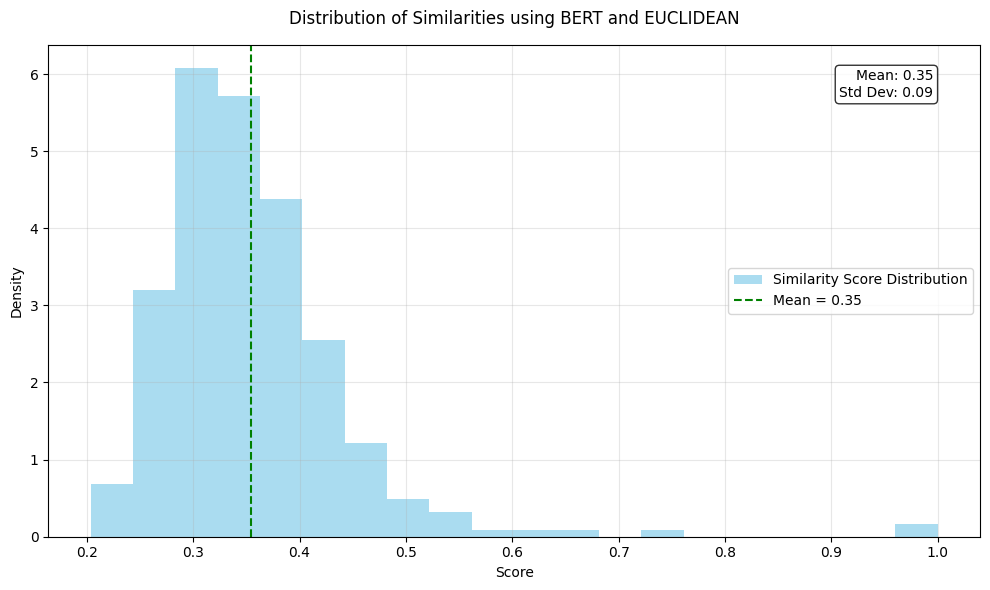

In [42]:
scores = similarities

# Create and display the plot
plot_score_distribution(scores, 'Distribution of Similarities using BERT and EUCLIDEAN')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def calculate_f1_score(method, embedding, threshold):
  # pg_cursor.execute(f"""
  # select 
	# coalesce(manual_labeling_matching.is_match, false) as label,
  #   (case when sentence_matching.similarity > {threshold} then true else false end) as predicted
  # from 
  #     distinct_pair
  # left join (
  #       select * from sentence_matching 
  #       where "method" = '{method}' and embedding = '{embedding}'
  # ) as sentence_matching on (
  #   (distinct_pair.id1 = sentence_matching.source_id and distinct_pair.id2 = sentence_matching.target_id) or 
  #   (distinct_pair.id1 = sentence_matching.target_id and distinct_pair.id2 = sentence_matching.source_id)
  # )
  # left join prompt_matching as manual_labeling_matching on (
  #   (distinct_pair.id1 = manual_labeling_matching.source_id and distinct_pair.id2 = manual_labeling_matching.target_id) or 
  #   (distinct_pair.id1 = manual_labeling_matching.target_id and distinct_pair.id2 = manual_labeling_matching.source_id)
  # )
  # """)
  pg_cursor.execute(f"""
  with result_cte as (
    select * from sentence_matching 
      where "method" = '{method}' and embedding = '{embedding}'
  )
select 
	coalesce(manual_labeling_matching.is_match, false) as label,
    (case when result_cte.similarity > {threshold} then true else false end) as predicted
  from 
      result_cte
  left join prompt_matching as manual_labeling_matching on (
    (result_cte.source_id = manual_labeling_matching.source_id and result_cte.target_id = manual_labeling_matching.target_id) or 
    (result_cte.source_id = manual_labeling_matching.target_id and result_cte.target_id = manual_labeling_matching.source_id)
  )
""")
  data_predict = pg_cursor.fetchall()
  label = []
  predicted = []
  for data in data_predict:
      label.append(data[0])
      predicted.append(data[1])
  accuracy = accuracy_score(label, predicted)
  recall = recall_score(label, predicted)
  precision = precision_score(label, predicted)
  f1 = f1_score(label, predicted)
  print(f'{threshold:.2f},{accuracy:.3f},{recall:.3f},{precision:.3f},{f1:.3f}')
  return accuracy, f1, recall, precision

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def draw_conffussion_matrix(method, embedding, threshold):
  #   pg_cursor.execute(f"""
  #   select 
	# coalesce(manual_labeling_matching.is_match, false) as label,
  #   (case when sentence_matching.similarity > {threshold} then true else false end) as predicted
  # from 
  #     distinct_pair
  # left join (
  #       select * from sentence_matching 
  #       where "method" = '{method}' and embedding = '{embedding}'
  # ) as sentence_matching on (
  #   (distinct_pair.id1 = sentence_matching.source_id and distinct_pair.id2 = sentence_matching.target_id) or 
  #   (distinct_pair.id1 = sentence_matching.target_id and distinct_pair.id2 = sentence_matching.source_id)
  # )
  # left join prompt_matching as manual_labeling_matching on (
  #   (distinct_pair.id1 = manual_labeling_matching.source_id and distinct_pair.id2 = manual_labeling_matching.target_id) or 
  #   (distinct_pair.id1 = manual_labeling_matching.target_id and distinct_pair.id2 = manual_labeling_matching.source_id)
  # )
  #   """)
    pg_cursor.execute(f"""
  with result_cte as (
    select * from sentence_matching 
      where "method" = '{method}' and embedding = '{embedding}'
  )
select 
	coalesce(manual_labeling_matching.is_match, false) as label,
    (case when result_cte.similarity > {threshold} then true else false end) as predicted
  from 
      result_cte
  left join prompt_matching as manual_labeling_matching on (
    (result_cte.source_id = manual_labeling_matching.source_id and result_cte.target_id = manual_labeling_matching.target_id) or 
    (result_cte.source_id = manual_labeling_matching.target_id and result_cte.target_id = manual_labeling_matching.source_id)
  )
""")
    data_predict = pg_cursor.fetchall()
    label = []
    predicted = []
    for data in data_predict:
        label.append(data[0])
        predicted.append(data[1])

    cm = confusion_matrix(y_true=label, y_pred=predicted, labels=[0, 1])
    # Create figure and axes
    plt.figure(figsize=(8, 6))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])

    # Add labels
    plt.title(f"Confusion Matrix {embedding} sentence-base")

    # Show plot
    plt.show()

In [30]:
thresholds = np.arange(0.3, 0.8, 0.01)
accuracy_scores = []
f1_scores = []

# Execute queries and collect accuracy scores
for threshold in thresholds:
    accuracy, f1, recall, precision = calculate_f1_score('EUCLIDEAN', 'BERT', threshold)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

0.30,0.349,0.826,0.231,0.362
0.31,0.379,0.744,0.227,0.348
0.32,0.432,0.734,0.244,0.366
0.33,0.467,0.681,0.247,0.363
0.34,0.500,0.662,0.258,0.371
0.35,0.539,0.643,0.273,0.383
0.36,0.588,0.570,0.287,0.382
0.37,0.640,0.560,0.323,0.410
0.38,0.658,0.493,0.325,0.392
0.39,0.694,0.464,0.357,0.403
0.40,0.719,0.420,0.382,0.400
0.41,0.725,0.396,0.387,0.391
0.42,0.741,0.348,0.407,0.375
0.43,0.767,0.304,0.467,0.368
0.44,0.775,0.285,0.492,0.361
0.45,0.779,0.275,0.509,0.357
0.46,0.780,0.232,0.516,0.320
0.47,0.777,0.188,0.500,0.274
0.48,0.782,0.174,0.537,0.263
0.49,0.788,0.174,0.581,0.268
0.50,0.796,0.174,0.667,0.276
0.51,0.801,0.174,0.720,0.280
0.52,0.803,0.155,0.800,0.259
0.53,0.807,0.155,0.889,0.263
0.54,0.803,0.135,0.875,0.234
0.55,0.798,0.116,0.857,0.204
0.56,0.803,0.116,1.000,0.208
0.57,0.803,0.116,1.000,0.208
0.58,0.803,0.116,1.000,0.208
0.59,0.798,0.097,1.000,0.176
0.60,0.798,0.097,1.000,0.176
0.61,0.798,0.097,1.000,0.176
0.62,0.798,0.097,1.000,0.176
0.63,0.798,0.097,1.000,0.176
0.64,0.794,0.0

In [32]:
print('COSINE', 'text-embedding-ada-002')
calculate_f1_score('COSINE', 'text-embedding-ada-002', 0.93)
print('EUCLIDEAN', 'text-embedding-ada-002')
calculate_f1_score('EUCLIDEAN', 'text-embedding-ada-002', 0.65)
print('COSINE', 'BERT')
calculate_f1_score('COSINE', 'BERT', 0.99)
print('EUCLIDEAN', 'BERT')
calculate_f1_score('EUCLIDEAN', 'BERT', 0.37)
print('COSINE', 'sBERT')
calculate_f1_score('COSINE', 'sBERT', 0.77)
print('EUCLIDEAN', 'sBERT')
calculate_f1_score('EUCLIDEAN', 'sBERT', 0.51)

COSINE text-embedding-ada-002
0.93,0.654,0.912,0.654,0.762
EUCLIDEAN text-embedding-ada-002
0.65,0.650,0.921,0.649,0.761
COSINE BERT
0.99,0.220,0.988,0.191,0.321
EUCLIDEAN BERT
0.37,0.640,0.560,0.323,0.410
COSINE sBERT
0.77,0.629,0.928,0.625,0.747
EUCLIDEAN sBERT
0.51,0.628,0.932,0.624,0.747


(0.6282183316168898,
 0.7473757872638208,
 0.9319371727748691,
 0.6238317757009346)

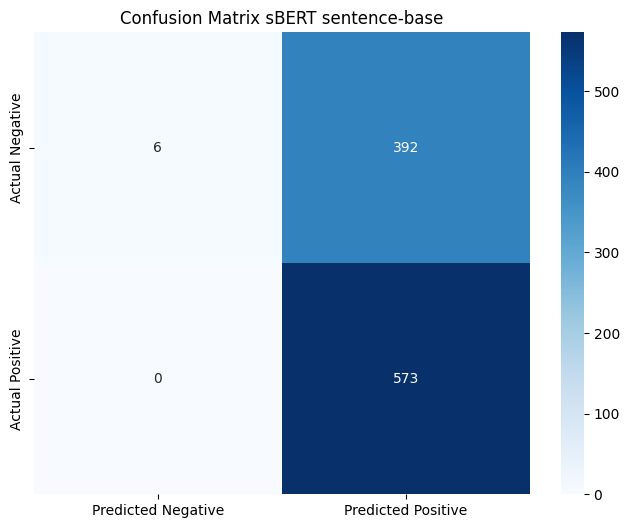

In [20]:
draw_conffussion_matrix('COSINE', 'sBERT', 0.68)